In [1]:
import numpy as np
import pandas as pd

In [2]:
import tensorflow as tf

In [3]:
import threading
import os
import cPickle as pickle
import logging
import pprint
import glob
import collections
import struct
import json
logging.basicConfig(format='%(asctime)s %(levelname)s: %(message)s', datefmt='%m/%d/%Y %I:%M:%S %p', level=logging.INFO)


In [4]:
logging.info('abc')

08/18/2017 02:21:08 AM INFO: abc


In [5]:
class GeneratorRunner(object):
    "Custom runner that that runs an generator in a thread and enqueues the outputs."

    def __init__(self, generator, placeholders, enqueue_op, close_op):
        self._generator = generator
        self._placeholders = placeholders
        self._enqueue_op = enqueue_op
        self._close_op = close_op

    def _run(self, sess, coord):
        try:
            while not coord.should_stop():
                try:
                    values = next(self._generator)

                    assert len(values) == len(self._placeholders), \
                        'generator values and placeholders must have the same length'

                    feed_dict = {placeholder: value \
                        for placeholder, value in zip(self._placeholders, values)}
                    sess.run(self._enqueue_op, feed_dict=feed_dict)
                except (StopIteration, tf.errors.OutOfRangeError, tf.errors.DeadlineExceededError, tf.errors.CancelledError) as e:
                    logging.warning ("%s %s %s", self.__class__.__name__, "exception:", str(type(e)))
                    try:
                        sess.run(self._close_op)
                    except Exception:
                        pass
                    return
        except Exception as ex:
            if coord:
                logging.info ("%s %s %s %s", self.__class__.__name__, "request stop from", self._run.__name__, str(ex))
                coord.request_stop(ex)
                pass
            else: 
                raise

    def create_threads(self, sess, coord=None, daemon=False, start=False):
        "Called by `start_queue_runners`."

        thread = threading.Thread(
            target=self._run,
            args=(sess, coord))

        if coord:
            coord.register_thread(thread)

        if daemon:
            thread.daemon = True

        if start:
            thread.start()

        return [thread]

def read_batch_generator(
        generator, dtypes, shapes, batch_size,
        queue_capacity=10000,
        allow_smaller_final_batch=False):
    "Reads values from an generator, queues, and batches."

    assert len(dtypes) == len(shapes), 'dtypes and shapes must have the same length'
    logging.info('shapes: %s, types: %s, batchsize: %d', str(shapes), str(dtypes), batch_size)
    queue = tf.FIFOQueue(
        capacity=queue_capacity,
        dtypes=dtypes,
        shapes=shapes)

    placeholders = [tf.placeholder(dtype, shape) for dtype, shape in zip(dtypes, shapes)]

    enqueue_op = queue.enqueue(placeholders)
    close_op = queue.close(cancel_pending_enqueues=True)
    global_close_ops.append(close_op)
    queue_runner = GeneratorRunner(generator, placeholders, enqueue_op, close_op)
    tf.train.add_queue_runner(queue_runner)

    if allow_smaller_final_batch:
        return queue.dequeue_up_to(batch_size)
    else:
        return queue.dequeue_many(batch_size)    

In [6]:
LEN1=64*2
import Queue,random
class MemoryGenerator(object):
    def __init__(self, daily_data,attrib_data, epochs=np.inf):
        self.daily_data = daily_data
        self.attrib_data = attrib_data        
        self.shuffle=True
        self.epochs = epochs
        self.N = len(self.daily_data)*10
        self.curr_epoch = 1
        self.curr_i = 0
        self.q = Queue.Queue()
        if self.shuffle:
            self.do_shuffle()
    def __iter__(self):
        return self
    def do_shuffle(self):
        idx = np.random.permutation(range(len(self.daily_data)))
        self.daily_data = self.daily_data[idx]     
        self.attrib_data = self.attrib_data[idx]
    def fill_queue(self):
        for _ in range(100):
            i=int(np.random.random()*len(self.daily_data))
            attrib_row=self.attrib_data[i]
            row=self.daily_data[i]
            len1=LEN1
            len2=60
            j= random.randint(len1,len(row)-1)
            x=row[j-len1:j]
            part_y=row[j:j+len2]
            y=np.zeros(len2,dtype=np.float32)
            y[:len(part_y)]=part_y
            mask=np.zeros(len2,dtype=np.float32)
            mask[:len(part_y)]= (part_y!=0)*1
            self.q.put((x.astype(np.float32),attrib_row.astype(np.float32),np.array(y,dtype=np.float32),mask))
    def __next__(self):
        return self.next()
    def next(self):
        if self.curr_i >= self.N:
            self.curr_i = 0
            self.curr_epoch += 1
            if self.curr_epoch > self.epochs: raise StopIteration
            if self.shuffle: 
                self.do_shuffle()
        if self.q.empty(): self.fill_queue()
        X1,X2, y,mask = self.q.get()
        self.curr_i += 1
        return X1,X2, y,mask 


In [7]:
def make_train_readers(daily_data,attrib_data, nrows=None, batchsize=60):
    print daily_data.shape, attrib_data.shape
    train_generator = MemoryGenerator(daily_data,attrib_data)
    return read_batch_generator(train_generator, [tf.float32, tf.float32, tf.float32, tf.float32], 
                                [(LEN1,), (12,), (60,),(60,)], batchsize, allow_smaller_final_batch=True),train_generator

In [8]:
locales=sorted([u'en', u'ja', u'de', u'fr', u'zh', u'ru', u'es'])
locale_map={v:u for u,v in enumerate(locales)}
locale_map

{u'de': 0, u'en': 1, u'es': 2, u'fr': 3, u'ja': 4, u'ru': 5, u'zh': 6}

In [9]:
access_map={u'all-access':0, u'mobile-web':1, u'desktop':2}
agent_map={u'all-agents':0, u'spider':1}
access_map,agent_map

({u'all-access': 0, u'desktop': 2, u'mobile-web': 1},
 {u'all-agents': 0, u'spider': 1})

In [10]:
def f_map(series, data_map):
    lst=[]
    keys=list(data_map.keys())
    for k in keys:
        lst.append(series.map(lambda u: (u==k)*1))
    df=pd.concat(lst,axis=1)
    df.columns=[series.name+"_"+u for u in keys]
    return df

In [11]:
def make_data():
    import pandas as pd
    csv_path="../input/newtrain_1.csv"
    data = pd.read_csv(csv_path, nrows=None)
    datecols=[u for u in data.columns if u.startswith("20")]
    daily_data=data[datecols].values.astype(np.float32)
    attrib_data=pd.concat([f_map(data.locale,locale_map),
                           f_map(data.agent,agent_map),
                           f_map(data.access,access_map)],axis=1).values.astype(np.float32)    
    print daily_data.shape,attrib_data.shape
    return daily_data,attrib_data

In [12]:
daily_data,attrib_data=make_data()

(145063, 550) (145063, 12)


In [13]:
print np.mean(daily_data==0)
#daily_data += (daily_data==0)*0.1
#print np.mean(daily_data==0)

0.0909115851232


In [14]:
if 0:
    global_close_ops = []
    #daily_data,attrib_data=make_data()
    _, generator=make_train_readers(daily_data,attrib_data)
    a,b,c,d= generator.next()
    #print a,b,c,d    
    print a.shape,b.shape,c.shape,d.shape


In [15]:
def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>" % size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    from IPython.display import clear_output, Image, display, HTML

    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph' + str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))


In [16]:
def weight_variable(shape, name):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial, name=name)

def bias_variable(shape, name):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial, name=name)

def dense(x, size, scope, with_activation=True):
    if 1:
        with tf.variable_scope(scope):
            w = weight_variable(shape=[int(x.get_shape()[-1]), size], name=None)
            b = bias_variable(shape=[size], name=None)
            h1 = tf.matmul(x, w) + b
            layer=tf.sigmoid(h1) if with_activation else h1
            print layer.get_shape()
    return layer,w,b
from tensorflow.contrib import rnn
def lstm(x,x2, n_hiddens, n_input, n_output, scope):
    if 1:
        with tf.variable_scope(scope):
            x = tf.reshape(x, [-1, n_input])
            x = tf.split(x,n_input,1)
            basic_rnn_cells = [rnn.BasicLSTMCell(n_hidden) for n_hidden in n_hiddens]
            rnn_cell = rnn.MultiRNNCell(basic_rnn_cells)
            outputs, states = rnn.static_rnn(rnn_cell, x, dtype=tf.float32) 
            concat_x=tf.concat([outputs[-1],x2],-1)
            print outputs[-1].get_shape(), concat_x.get_shape()             
            return concat_x

def get_Xy(x_size,x2_size,y_size):
    X = tf.placeholder("float", shape=[None, x_size], name='input_x')
    X2 = tf.placeholder("float", shape=[None, x2_size], name='input_x2')    
    l2_scale = tf.placeholder(tf.float32, name='l2_scale')
    y = tf.placeholder("float", shape=[None, y_size], name='input_y')
    mask = tf.placeholder("float", shape=[None, y_size], name='mask')
    return X,X2, y,mask, l2_scale

In [17]:
class MyModel(object):
    def __init__(self, x_size,y_size, n_hiddens,l2_scale,phase=True ):
        self.phase=phase
        n_hiddens=n_hiddens
        self.graph = tf.Graph()
        self.all_denses = []
        with self.graph.as_default(): 
            self.X, self.X2, self.y, self.mask, self.l2_scale = get_Xy(x_size,12, y_size)
            assert(x_size == self.X.get_shape()[1])
            with tf.variable_scope("nodes"):
                self.X, self.y, self.loss, self.smape \
                     = self.make_model(x_size=x_size, y_size=y_size, n_hiddens=n_hiddens)

            
            with tf.variable_scope('saver'):
                    self.saver = tf.train.Saver()

            update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
            with tf.variable_scope('optimizer'):
                with tf.control_dependencies(update_ops):
                    self.optimizer = tf.train.AdamOptimizer()#.minimize(self.loss)
                    gvs = self.optimizer.compute_gradients(self.loss)
                    capped_gvs = [(tf.clip_by_value(grad, -1., 1.), var) for grad, var in gvs]
                    self.train_op = self.optimizer.apply_gradients(capped_gvs)
        self._session = None    
    @property
    def session(self): 
        if self._session is None:
            config = tf.ConfigProto(log_device_placement=True)
            config.gpu_options.per_process_gpu_memory_fraction = 0.5  # don't hog all vRAM
            self._session = tf.Session(graph=self.graph,config=config)
        return self._session
    
    def close_session(self):
        if self._session is not None:
            self._session.close()
            self._session = None
    def initialize(self, session=None):
        with self.graph.as_default():
            init_op = tf.global_variables_initializer()        
        self.session.run(init_op) 
        return self.session
 
        
    def make_model(self, x_size,y_size, n_hiddens):
        X_raw, y  = self.X, self.y 
        logging.debug ("%s %s", self.__class__.__name__,
                       'input shapes: X={},y={}'.format(X_raw.get_shape(), None if y is None else y.get_shape()))

        h = tf.log(X_raw+1)
        #h=     tf.layers.batch_normalization(h,center=False, scale=True,training=self.phase)
        
        h=lstm(h,self.X2, [n_hiddens[0]], x_size, y_size, 'lstm')
        for i in range(0, len(n_hiddens)):
            n_hidden = n_hiddens[i]
            h, w,b = dense(h, n_hidden,'dense')
            self.all_denses.append((h,w,b))

        logits_sum,_,_=dense(h,y_size,'dense',with_activation=False)
        
        with tf.variable_scope("loss"):
            epsilon = 1e-7        
            l2_loss = 0
            if 1:  # self.l2_scale > 0:
                logging.info('use l2 reg scale %s', str(self.l2_scale))
                for _,w,_ in self.all_denses:
                    l2_loss = l2_loss + tf.reduce_sum(w ** 2)
                l2_loss = l2_loss * self.l2_scale
                self.l2_loss = l2_loss
            if 1:
                predictions = tf.identity(logits_sum, name='prediction')
                float_labels = tf.cast(y, tf.float32)
                
                ratio=predictions/(float_labels+1e-4)
                additional_loss= 0.02*tf.cast(ratio>9,tf.float32)*tf.abs(ratio)\
                    +0.02*tf.cast(predictions<0.0,tf.float32)*tf.abs(predictions)
                additional_loss = tf.reduce_sum(additional_loss*self.mask)/tf.reduce_sum(self.mask)
                self.additional_loss=additional_loss
                this_loss =  tf.abs(predictions-float_labels)/(tf.abs(predictions)+tf.abs(float_labels))
                this_loss=this_loss*self.mask
                this_loss = tf.identity(2* tf.reduce_sum(this_loss)/tf.reduce_sum(self.mask), name='smape')                          
                loss = this_loss + l2_loss+additional_loss

            logging.info ('%s %s %s', self.__class__.__name__, 'logits shape', logits_sum.get_shape())

        return X_raw, y, loss, this_loss
 
    
    def save(self, prefix, ckpt=1):
        checkpoint_name = '{}/model_{}'.format(prefix, 0)
        self.saver.save(self.session, checkpoint_name, global_step=ckpt)

    def load(self, prefix, ckpt=1):
        self.saver.restore(self.session, '{}/model_{}-{}'.format(prefix, self.model_id, ckpt))


In [18]:
if 0:
    tf.reset_default_graph()
    model = MyModel(x_size=5, y_size=2, n_hiddens=[2,2], l2_scale=0.1)
    model.initialize()
    #print [n.op for n in model.graph.as_graph_def().node];
    show_graph(model.graph.as_graph_def())

In [19]:
def svd_orthonormal(shape):
    print(shape)
    if len(shape) < 2:
        raise RuntimeError("Only shapes of length 2 or more are supported.")
    flat_shape = (shape[0], np.prod(shape[1:]))
    a = np.random.standard_normal(flat_shape)
    u, _, v = np.linalg.svd(a, full_matrices=False)
    q = u if u.shape == flat_shape else v
    q = q.reshape(shape)
    return q

def get_activations(model, h, X_batch):
    activations = model.session.run(h, feed_dict={model.X:X_batch})
    return activations

def LSUVinit(model, batch):
    # only these layer classes considered for LSUV initialization; add more if needed    
    margin = 0.1
    max_iter = 10
    layers_inintialized = 0
    for h,w,_ in model.all_denses:
        # avoid small layers where activation variance close to zero, esp. for small batches
        if np.prod(h.get_shape()) < 32:
            print(h, 'too small')
            continue
        logging.info('LSUV initializing' + str(h))
        layers_inintialized += 1
        needed_variance = 1.0
        
        # print ('pre',np.sum(model.session.run(np.abs(w))))
        weights = svd_orthonormal(w.get_shape())
        model.session.run(tf.assign(w, weights))
        # print (model.session.run(w),weights)
        # print ('post',np.sum(model.session.run(np.abs(w))),np.sum(np.abs(weights)))        
        acts1 = get_activations(model, h, batch)
        # print (acts1,needed_variance)
        
        var1 = np.var(acts1)
        iter1 = 0
        logging.info('var1 %f', var1)
        while (abs(needed_variance - var1) > margin):
            if np.abs(np.sqrt(var1)) < 1e-7: break  # avoid zero division
            weights /= np.sqrt(var1) / np.sqrt(needed_variance)
            model.session.run(tf.assign(w, weights))
            acts1 = get_activations(model, h, batch)
            var1 = np.var(acts1)
            iter1 += 1
            # print (acts1)
            logging.info('var1 %f', var1)
            if iter1 > max_iter:
                break
    logging.info('LSUV: total layers initialized %d', layers_inintialized)   
    return model


In [20]:

class BN(object):
    def __init__(self, x_size, y_size, n_hiddens, l2_scale=0.0, prefix='./tmp'):
        self.x_size = x_size
        self.y_size=y_size
        self.n_hiddens = n_hiddens
        self.l2_scale = l2_scale
        self.prefix = prefix
    

    def train_one_epoch(self, n_epoch, sess, model, train_reader,test_reader, coord):
        count = 0
        loss = []; l2_loss = [];smape_loss=[]
        while not coord.should_stop():
            try:
                if  True:
                    X,X2, y,mask = sess.run(train_reader)
                    feed_dict = {model.X:X, model.X2:X2, model.y:y, model.mask:mask, model.l2_scale: self.l2_scale}
                    _, a, aa,aaa = model.session.run([model.train_op, model.loss, model.smape,model.l2_loss], 
                                                    feed_dict=feed_dict)
                    loss.append(a)
                    smape_loss.append(aa)                    
                    l2_loss.append(aaa)
                    count += len(y)
                    if count % self.net_train_report_intev == 0:

                        logging.info ('[epoch {}][step {}] AVG LOSS: {}, smape: {}, l2: {}'.format(
                            n_epoch, count, np.mean(loss),np.mean(smape_loss), np.mean(l2_loss)))
                        loss = []; l2_loss = [];smape_loss=[]
                        self.read_params()

                    if count >= self.net_train_eval_intev:
                        X,X2, y,mask = sess.run(test_reader)
                        feed_dict = {model.X:X, model.X2:X2, model.y:y, model.mask:mask, model.l2_scale: self.l2_scale}
                        a, aa = model.session.run([ model.loss, model.smape], 
                                                    feed_dict=feed_dict)
                        logging.info ('[epoch {}] Valid LOSS: {}, smape: {}'.format(
                            n_epoch, a, aa))
                        return 0
            except tf.errors.OutOfRangeError:
                logging.info (self.__class__.__name__, 'Done with read')
                logging.info (self.__class__.__name__, "request stop from", self.train_one_epoch.__name__)                
                coord.request_stop()
                for o in global_close_ops: sess.run(o)
                return 1                                      
            except:
                raise           
        return 0


    def save_net(self, sess, model, n_epoch):
        model.save(prefix=self.prefix, ckpt=n_epoch)

    def train(self, daily_data,attrib_data, net_round,net_train_report_intev,net_train_eval_intev):
        self.net_train_report_intev=net_train_report_intev
        self.net_train_eval_intev=net_train_eval_intev
        model = MyModel(x_size=self.x_size, y_size=self.y_size, n_hiddens=self.n_hiddens,
                             l2_scale=self.l2_scale)
        model.initialize()
        config = tf.ConfigProto(log_device_placement=True)
        config.gpu_options.per_process_gpu_memory_fraction = 0.5  # don't hog all vRAM
        # config.operation_timeout_in_ms = 10000  # terminate on long hangs
        idx=np.random.permutation(range(len(daily_data)))
        trainidx=idx[:int(len(idx)*0.8)]
        testidx=idx[int(len(idx)*0.8):]
        train_daily_data=daily_data[trainidx]
        train_attrib_data=attrib_data[trainidx]
        test_daily_data=daily_data[testidx]
        test_attrib_data=attrib_data[testidx] 
        print train_daily_data.shape,test_daily_data.shape
        with tf.Session(config=config) as sess:
            train_reader,_ = make_train_readers(train_daily_data,train_attrib_data,batchsize=batch_size,nrows=None)            
            test_reader,_ = make_train_readers(test_daily_data,test_attrib_data,batchsize=batch_size*20,nrows=None)            
            
            coord = tf.train.Coordinator()
            threads = tf.train.start_queue_runners(sess=sess, coord=coord)
            res = None
            try:
                if 0:
                    logging.info('Use LSUV initialization')
                    batch = np.concatenate([sess.run(train_reader)[0] for _ in range(100)])
                    LSUVinit(model, batch)
                for j in range(net_round):
                    logging.info ('[epoch {}] start net training'.format(j))
                    if self.train_one_epoch(j, sess, model, train_reader, test_reader,coord) is None:
                        raise Exception("train error") 
                    self.save_net(sess=sess, model=model, n_epoch=0)
            except:
                raise 
            finally:
                logging.info ('%s %s %s', self.__class__.__name__, "request stop from", self.train.__name__)
                for o in global_close_ops: sess.run(o)                
                coord.request_stop()

            coord.join(threads)
            sess.close()
            model.close_session()
            return 

    def read_params(self):
	try:
	    with open('param.txt') as f:
	        m = json.load(f)
 	    a = m["l2_scale"]
	    if self.l2_scale != a: 
		logging.info("Change l2_scale from %e to %e", self.l2_scale, a)
	     	self.l2_scale = a
	except:
	    logging.error('read params failed')


In [21]:
daily_data.shape

(145063, 550)

In [22]:
l2_scale = 1e-8

batch_size = 256

if 0: #test
    n_hiddens=[10]
    net_round=10
    net_train_report_intev=batch_size*10
    net_train_eval_intev=10000
else:
    n_hiddens=[512,512]    
    net_round=200
    net_train_report_intev=batch_size*100
    net_train_eval_intev=batch_size*1000

In [23]:
global_close_ops = []
tf.reset_default_graph()       
model = BN(x_size=LEN1, y_size=60, n_hiddens=n_hiddens, prefix='tmp_pred60_lstm_512_nozero_xnopad_l2', l2_scale=l2_scale)
model.train(daily_data,attrib_data,  \
           net_round=net_round,  net_train_report_intev=net_train_report_intev,
            net_train_eval_intev=net_train_eval_intev )  

08/18/2017 02:21:27 AM INFO: use l2 reg scale Tensor("l2_scale:0", dtype=float32)
08/18/2017 02:21:27 AM INFO: MyModel logits shape (?, 60)


(?, 512) (?, 524)
(?, 512)
(?, 512)
(?, 60)


08/18/2017 02:21:40 AM INFO: shapes: [(128,), (12,), (60,), (60,)], types: [tf.float32, tf.float32, tf.float32, tf.float32], batchsize: 256
08/18/2017 02:21:40 AM INFO: shapes: [(128,), (12,), (60,), (60,)], types: [tf.float32, tf.float32, tf.float32, tf.float32], batchsize: 5120
08/18/2017 02:21:40 AM INFO: [epoch 0] start net training


(116050, 550) (29013, 550)
(116050, 550) (116050, 12)
(29013, 550) (29013, 12)


08/18/2017 02:22:05 AM INFO: [epoch 0][step 25600] AVG LOSS: 1.47796416283, smape: 1.47206115723, l2: 4.18230847572e-05
08/18/2017 02:22:25 AM INFO: [epoch 0][step 51200] AVG LOSS: 1.40133607388, smape: 1.38332843781, l2: 4.21006843681e-05
08/18/2017 02:22:44 AM INFO: [epoch 0][step 76800] AVG LOSS: 1.38028228283, smape: 1.35257267952, l2: 4.21293370891e-05
08/18/2017 02:23:04 AM INFO: [epoch 0][step 102400] AVG LOSS: 1.3825199604, smape: 1.34574234486, l2: 4.21188597102e-05
08/18/2017 02:23:23 AM INFO: [epoch 0][step 128000] AVG LOSS: 1.37300527096, smape: 1.33051800728, l2: 4.20839860453e-05
08/18/2017 02:23:43 AM INFO: [epoch 0][step 153600] AVG LOSS: 1.37078404427, smape: 1.32230198383, l2: 4.20323849539e-05
08/18/2017 02:24:02 AM INFO: [epoch 0][step 179200] AVG LOSS: 1.36718845367, smape: 1.31186819077, l2: 4.19644602516e-05
08/18/2017 02:24:22 AM INFO: [epoch 0][step 204800] AVG LOSS: 1.368683815, smape: 1.30959558487, l2: 4.18823765358e-05
08/18/2017 02:24:41 AM INFO: [epoch 0]

08/18/2017 02:41:37 AM INFO: [epoch 6][step 25600] AVG LOSS: 0.51215004921, smape: 0.511001110077, l2: 6.48502464173e-05
08/18/2017 02:41:53 AM INFO: [epoch 6][step 51200] AVG LOSS: 0.511516451836, smape: 0.510365724564, l2: 6.49259527563e-05
08/18/2017 02:42:13 AM INFO: [epoch 6][step 76800] AVG LOSS: 0.505318880081, smape: 0.504024744034, l2: 6.50063884677e-05
08/18/2017 02:42:32 AM INFO: [epoch 6][step 102400] AVG LOSS: 0.508508741856, smape: 0.507254123688, l2: 6.50229849271e-05
08/18/2017 02:42:52 AM INFO: [epoch 6][step 128000] AVG LOSS: 0.506480395794, smape: 0.50510686636, l2: 6.50683432468e-05
08/18/2017 02:43:11 AM INFO: [epoch 6][step 153600] AVG LOSS: 0.504447221756, smape: 0.503167510033, l2: 6.51064037811e-05
08/18/2017 02:43:31 AM INFO: [epoch 6][step 179200] AVG LOSS: 0.504114985466, smape: 0.502753078938, l2: 6.51929731248e-05
08/18/2017 02:43:50 AM INFO: [epoch 6][step 204800] AVG LOSS: 0.498628973961, smape: 0.497500777245, l2: 6.52491653454e-05
08/18/2017 02:44:10 A

08/18/2017 03:01:10 AM INFO: [epoch 12][step 25600] AVG LOSS: 0.449717253447, smape: 0.44825553894, l2: 7.17995717423e-05
08/18/2017 03:01:29 AM INFO: [epoch 12][step 51200] AVG LOSS: 0.452087491751, smape: 0.450230687857, l2: 7.18975425116e-05
08/18/2017 03:01:46 AM INFO: [epoch 12][step 76800] AVG LOSS: 0.448721915483, smape: 0.447154045105, l2: 7.19967647456e-05
08/18/2017 03:02:05 AM INFO: [epoch 12][step 102400] AVG LOSS: 0.447218030691, smape: 0.445945352316, l2: 7.21616233932e-05
08/18/2017 03:02:25 AM INFO: [epoch 12][step 128000] AVG LOSS: 0.447901427746, smape: 0.446177363396, l2: 7.23122648196e-05
08/18/2017 03:02:44 AM INFO: [epoch 12][step 153600] AVG LOSS: 0.445968598127, smape: 0.444345861673, l2: 7.2411938163e-05
08/18/2017 03:03:04 AM INFO: [epoch 12][step 179200] AVG LOSS: 0.447750240564, smape: 0.4461350739, l2: 7.23122575437e-05
08/18/2017 03:03:23 AM INFO: [epoch 12][step 204800] AVG LOSS: 0.446591258049, smape: 0.444659531116, l2: 7.2465321864e-05
08/18/2017 03:03

08/18/2017 03:20:18 AM INFO: [epoch 18] start net training
08/18/2017 03:20:37 AM INFO: [epoch 18][step 25600] AVG LOSS: 0.42725327611, smape: 0.425679624081, l2: 9.01663006516e-05
08/18/2017 03:20:57 AM INFO: [epoch 18][step 51200] AVG LOSS: 0.426699340343, smape: 0.424881517887, l2: 9.06296263565e-05
08/18/2017 03:21:16 AM INFO: [epoch 18][step 76800] AVG LOSS: 0.427564710379, smape: 0.425793141127, l2: 9.10460948944e-05
08/18/2017 03:21:36 AM INFO: [epoch 18][step 102400] AVG LOSS: 0.428634464741, smape: 0.427121192217, l2: 9.12796458579e-05
08/18/2017 03:21:53 AM INFO: [epoch 18][step 128000] AVG LOSS: 0.428794443607, smape: 0.427161365747, l2: 9.11893948796e-05
08/18/2017 03:22:13 AM INFO: [epoch 18][step 153600] AVG LOSS: 0.425021529198, smape: 0.423067271709, l2: 9.12169998628e-05
08/18/2017 03:22:32 AM INFO: [epoch 18][step 179200] AVG LOSS: 0.427655100822, smape: 0.425975114107, l2: 9.18094083318e-05
08/18/2017 03:22:52 AM INFO: [epoch 18][step 204800] AVG LOSS: 0.42746552825,

08/18/2017 03:39:45 AM INFO: [epoch 23] Valid LOSS: 0.427592158318, smape: 0.424805104733
08/18/2017 03:39:47 AM INFO: [epoch 24] start net training
08/18/2017 03:40:07 AM INFO: [epoch 24][step 25600] AVG LOSS: 0.419866979122, smape: 0.417234867811, l2: 0.000108553824248
08/18/2017 03:40:26 AM INFO: [epoch 24][step 51200] AVG LOSS: 0.421730995178, smape: 0.41980561614, l2: 0.000108679458208
08/18/2017 03:40:46 AM INFO: [epoch 24][step 76800] AVG LOSS: 0.418437600136, smape: 0.416909635067, l2: 0.000108728912892
08/18/2017 03:41:05 AM INFO: [epoch 24][step 102400] AVG LOSS: 0.420049101114, smape: 0.417638272047, l2: 0.000109030144813
08/18/2017 03:41:25 AM INFO: [epoch 24][step 128000] AVG LOSS: 0.416948735714, smape: 0.414726495743, l2: 0.000109309417894
08/18/2017 03:41:43 AM INFO: [epoch 24][step 153600] AVG LOSS: 0.418027341366, smape: 0.416153877974, l2: 0.000109491265903
08/18/2017 03:42:01 AM INFO: [epoch 24][step 179200] AVG LOSS: 0.419473052025, smape: 0.417780607939, l2: 0.000

08/18/2017 03:59:13 AM INFO: [epoch 29] Valid LOSS: 0.413052797318, smape: 0.411405712366
08/18/2017 03:59:14 AM INFO: [epoch 30] start net training
08/18/2017 03:59:34 AM INFO: [epoch 30][step 25600] AVG LOSS: 0.417249292135, smape: 0.414758116007, l2: 0.000121623903397
08/18/2017 03:59:53 AM INFO: [epoch 30][step 51200] AVG LOSS: 0.412462115288, smape: 0.411043345928, l2: 0.000121614903037
08/18/2017 04:00:13 AM INFO: [epoch 30][step 76800] AVG LOSS: 0.415144085884, smape: 0.413408309221, l2: 0.000121840763313
08/18/2017 04:00:32 AM INFO: [epoch 30][step 102400] AVG LOSS: 0.415034562349, smape: 0.413263231516, l2: 0.000122021716379
08/18/2017 04:00:52 AM INFO: [epoch 30][step 128000] AVG LOSS: 0.416758388281, smape: 0.415095448494, l2: 0.000122228244436
08/18/2017 04:01:11 AM INFO: [epoch 30][step 153600] AVG LOSS: 0.416227251291, smape: 0.414046943188, l2: 0.000122243363876
08/18/2017 04:01:31 AM INFO: [epoch 30][step 179200] AVG LOSS: 0.414214909077, smape: 0.412316352129, l2: 0.00

08/18/2017 04:18:45 AM INFO: [epoch 35] Valid LOSS: 0.407166421413, smape: 0.406026512384
08/18/2017 04:18:46 AM INFO: [epoch 36] start net training
08/18/2017 04:19:05 AM INFO: [epoch 36][step 25600] AVG LOSS: 0.410180777311, smape: 0.408881723881, l2: 0.000137592622195
08/18/2017 04:19:25 AM INFO: [epoch 36][step 51200] AVG LOSS: 0.41061219573, smape: 0.408960461617, l2: 0.00013814563863
08/18/2017 04:19:44 AM INFO: [epoch 36][step 76800] AVG LOSS: 0.409593760967, smape: 0.408301085234, l2: 0.000138397736009
08/18/2017 04:20:04 AM INFO: [epoch 36][step 102400] AVG LOSS: 0.411887049675, smape: 0.410083919764, l2: 0.000138505289215
08/18/2017 04:20:23 AM INFO: [epoch 36][step 128000] AVG LOSS: 0.409830212593, smape: 0.40804463625, l2: 0.000138858275022
08/18/2017 04:20:43 AM INFO: [epoch 36][step 153600] AVG LOSS: 0.412027537823, smape: 0.410508692265, l2: 0.000139350115205
08/18/2017 04:21:02 AM INFO: [epoch 36][step 179200] AVG LOSS: 0.411783456802, smape: 0.409638315439, l2: 0.00013

08/18/2017 04:38:19 AM INFO: [epoch 41] Valid LOSS: 0.400371164083, smape: 0.398228347301
08/18/2017 04:38:21 AM INFO: [epoch 42] start net training
08/18/2017 04:38:37 AM INFO: [epoch 42][step 25600] AVG LOSS: 0.406089901924, smape: 0.404038846493, l2: 0.000159896182595
08/18/2017 04:38:56 AM INFO: [epoch 42][step 51200] AVG LOSS: 0.407588362694, smape: 0.406657248735, l2: 0.000160374096595
08/18/2017 04:39:16 AM INFO: [epoch 42][step 76800] AVG LOSS: 0.406200110912, smape: 0.404909819365, l2: 0.000160659808898
08/18/2017 04:39:35 AM INFO: [epoch 42][step 102400] AVG LOSS: 0.406976699829, smape: 0.404904901981, l2: 0.000160849827807
08/18/2017 04:39:55 AM INFO: [epoch 42][step 128000] AVG LOSS: 0.408450037241, smape: 0.406968027353, l2: 0.000161159900017
08/18/2017 04:40:14 AM INFO: [epoch 42][step 153600] AVG LOSS: 0.40449360013, smape: 0.402932673693, l2: 0.000161659700098
08/18/2017 04:40:34 AM INFO: [epoch 42][step 179200] AVG LOSS: 0.405086785555, smape: 0.403321534395, l2: 0.000

08/18/2017 04:57:49 AM INFO: [epoch 47] Valid LOSS: 0.395992696285, smape: 0.394231319427
08/18/2017 04:57:51 AM INFO: [epoch 48] start net training
08/18/2017 04:58:10 AM INFO: [epoch 48][step 25600] AVG LOSS: 0.401919066906, smape: 0.400687664747, l2: 0.000182439558557
08/18/2017 04:58:29 AM INFO: [epoch 48][step 51200] AVG LOSS: 0.398704975843, smape: 0.397035002708, l2: 0.00018274730246
08/18/2017 04:58:47 AM INFO: [epoch 48][step 76800] AVG LOSS: 0.399047881365, smape: 0.397924810648, l2: 0.000182981122634
08/18/2017 04:59:07 AM INFO: [epoch 48][step 102400] AVG LOSS: 0.40069180727, smape: 0.399177849293, l2: 0.00018327923317
08/18/2017 04:59:26 AM INFO: [epoch 48][step 128000] AVG LOSS: 0.40215870738, smape: 0.400875508785, l2: 0.000183511103387
08/18/2017 04:59:46 AM INFO: [epoch 48][step 153600] AVG LOSS: 0.402504771948, smape: 0.4008474648, l2: 0.000183748139534
08/18/2017 05:00:05 AM INFO: [epoch 48][step 179200] AVG LOSS: 0.400762289762, smape: 0.399188071489, l2: 0.00018399

08/18/2017 05:17:19 AM INFO: [epoch 53] Valid LOSS: 0.400701165199, smape: 0.398819804192
08/18/2017 05:17:21 AM INFO: [epoch 54] start net training
08/18/2017 05:17:41 AM INFO: [epoch 54][step 25600] AVG LOSS: 0.40143802762, smape: 0.399460881948, l2: 0.000202196330065
08/18/2017 05:18:00 AM INFO: [epoch 54][step 51200] AVG LOSS: 0.400582313538, smape: 0.398833036423, l2: 0.000202705530683
08/18/2017 05:18:20 AM INFO: [epoch 54][step 76800] AVG LOSS: 0.399484723806, smape: 0.397820025682, l2: 0.000203158153454
08/18/2017 05:18:36 AM INFO: [epoch 54][step 102400] AVG LOSS: 0.401159524918, smape: 0.399816781282, l2: 0.000203638614039
08/18/2017 05:18:56 AM INFO: [epoch 54][step 128000] AVG LOSS: 0.402643293142, smape: 0.401144683361, l2: 0.000203720002901
08/18/2017 05:19:15 AM INFO: [epoch 54][step 153600] AVG LOSS: 0.399302452803, smape: 0.397252768278, l2: 0.000203783682082
08/18/2017 05:19:35 AM INFO: [epoch 54][step 179200] AVG LOSS: 0.399353533983, smape: 0.398037552834, l2: 0.000

08/18/2017 05:36:49 AM INFO: [epoch 59] Valid LOSS: 0.393378674984, smape: 0.392354875803
08/18/2017 05:36:50 AM INFO: [epoch 60] start net training
08/18/2017 05:37:10 AM INFO: [epoch 60][step 25600] AVG LOSS: 0.401553660631, smape: 0.400130718946, l2: 0.000220113812247
08/18/2017 05:37:29 AM INFO: [epoch 60][step 51200] AVG LOSS: 0.39873495698, smape: 0.397378474474, l2: 0.000220300673391
08/18/2017 05:37:48 AM INFO: [epoch 60][step 76800] AVG LOSS: 0.399891346693, smape: 0.398655444384, l2: 0.000220713685849
08/18/2017 05:38:08 AM INFO: [epoch 60][step 102400] AVG LOSS: 0.397727131844, smape: 0.396641045809, l2: 0.000221088674152
08/18/2017 05:38:26 AM INFO: [epoch 60][step 128000] AVG LOSS: 0.396057397127, smape: 0.394414335489, l2: 0.000221379232244
08/18/2017 05:38:45 AM INFO: [epoch 60][step 153600] AVG LOSS: 0.399738073349, smape: 0.39833521843, l2: 0.000221640453674
08/18/2017 05:39:05 AM INFO: [epoch 60][step 179200] AVG LOSS: 0.397566825151, smape: 0.396262049675, l2: 0.0002

08/18/2017 05:56:20 AM INFO: [epoch 65] Valid LOSS: 0.397446423769, smape: 0.395926833153
08/18/2017 05:56:22 AM INFO: [epoch 66] start net training
08/18/2017 05:56:41 AM INFO: [epoch 66][step 25600] AVG LOSS: 0.393939375877, smape: 0.392306774855, l2: 0.000241312794969
08/18/2017 05:57:00 AM INFO: [epoch 66][step 51200] AVG LOSS: 0.39514529705, smape: 0.393489390612, l2: 0.000241538582486
08/18/2017 05:57:20 AM INFO: [epoch 66][step 76800] AVG LOSS: 0.393683969975, smape: 0.39253243804, l2: 0.00024184997892
08/18/2017 05:57:39 AM INFO: [epoch 66][step 102400] AVG LOSS: 0.396711498499, smape: 0.39515799284, l2: 0.000242160633206
08/18/2017 05:57:59 AM INFO: [epoch 66][step 128000] AVG LOSS: 0.396781235933, smape: 0.395214349031, l2: 0.000242636655457
08/18/2017 05:58:18 AM INFO: [epoch 66][step 153600] AVG LOSS: 0.395171254873, smape: 0.393604665995, l2: 0.0002428896114
08/18/2017 05:58:36 AM INFO: [epoch 66][step 179200] AVG LOSS: 0.398750424385, smape: 0.397144734859, l2: 0.00024356

08/18/2017 06:15:50 AM INFO: [epoch 71] Valid LOSS: 0.387555450201, smape: 0.386452615261
08/18/2017 06:15:52 AM INFO: [epoch 72] start net training
08/18/2017 06:16:11 AM INFO: [epoch 72][step 25600] AVG LOSS: 0.39628136158, smape: 0.394485741854, l2: 0.000256793689914
08/18/2017 06:16:31 AM INFO: [epoch 72][step 51200] AVG LOSS: 0.395580112934, smape: 0.394428759813, l2: 0.000256817496847
08/18/2017 06:16:50 AM INFO: [epoch 72][step 76800] AVG LOSS: 0.397825270891, smape: 0.395858943462, l2: 0.000257156032603
08/18/2017 06:17:10 AM INFO: [epoch 72][step 102400] AVG LOSS: 0.395513981581, smape: 0.39339825511, l2: 0.000257423263974
08/18/2017 06:17:29 AM INFO: [epoch 72][step 128000] AVG LOSS: 0.395228385925, smape: 0.393663048744, l2: 0.000257576117292
08/18/2017 06:17:49 AM INFO: [epoch 72][step 153600] AVG LOSS: 0.393732756376, smape: 0.392359375954, l2: 0.000257998501183
08/18/2017 06:18:08 AM INFO: [epoch 72][step 179200] AVG LOSS: 0.396248847246, smape: 0.394635289907, l2: 0.0002

08/18/2017 06:35:24 AM INFO: [epoch 77] Valid LOSS: 0.391017228365, smape: 0.388425350189
08/18/2017 06:35:25 AM INFO: [epoch 78] start net training
08/18/2017 06:35:45 AM INFO: [epoch 78][step 25600] AVG LOSS: 0.39341378212, smape: 0.391539543867, l2: 0.000270968273981
08/18/2017 06:36:04 AM INFO: [epoch 78][step 51200] AVG LOSS: 0.396142929792, smape: 0.394586592913, l2: 0.000271204247838
08/18/2017 06:36:24 AM INFO: [epoch 78][step 76800] AVG LOSS: 0.397037506104, smape: 0.394542425871, l2: 0.000271216675173
08/18/2017 06:36:43 AM INFO: [epoch 78][step 102400] AVG LOSS: 0.398235321045, smape: 0.396786808968, l2: 0.000271413417067
08/18/2017 06:37:03 AM INFO: [epoch 78][step 128000] AVG LOSS: 0.395025521517, smape: 0.393603593111, l2: 0.000271814904409
08/18/2017 06:37:22 AM INFO: [epoch 78][step 153600] AVG LOSS: 0.392853885889, smape: 0.391181588173, l2: 0.000272074015811
08/18/2017 06:37:42 AM INFO: [epoch 78][step 179200] AVG LOSS: 0.393867880106, smape: 0.392429322004, l2: 0.000

08/18/2017 06:54:58 AM INFO: [epoch 83] Valid LOSS: 0.389313608408, smape: 0.388036936522
08/18/2017 06:54:59 AM INFO: [epoch 84] start net training
08/18/2017 06:55:18 AM INFO: [epoch 84][step 25600] AVG LOSS: 0.394362002611, smape: 0.392625033855, l2: 0.000285190879367
08/18/2017 06:55:37 AM INFO: [epoch 84][step 51200] AVG LOSS: 0.39815479517, smape: 0.396509319544, l2: 0.000285393471131
08/18/2017 06:55:56 AM INFO: [epoch 84][step 76800] AVG LOSS: 0.396034121513, smape: 0.394604235888, l2: 0.000285689427983
08/18/2017 06:56:16 AM INFO: [epoch 84][step 102400] AVG LOSS: 0.395003348589, smape: 0.393114358187, l2: 0.000285975227598
08/18/2017 06:56:35 AM INFO: [epoch 84][step 128000] AVG LOSS: 0.394217580557, smape: 0.392842829227, l2: 0.000286206806777
08/18/2017 06:56:55 AM INFO: [epoch 84][step 153600] AVG LOSS: 0.395361542702, smape: 0.393639206886, l2: 0.000286664580926
08/18/2017 06:57:14 AM INFO: [epoch 84][step 179200] AVG LOSS: 0.392356842756, smape: 0.390613377094, l2: 0.000

08/18/2017 07:14:27 AM INFO: [epoch 89] Valid LOSS: 0.390831261873, smape: 0.389661371708
08/18/2017 07:14:29 AM INFO: [epoch 90] start net training
08/18/2017 07:14:48 AM INFO: [epoch 90][step 25600] AVG LOSS: 0.395308196545, smape: 0.393869370222, l2: 0.000299588369671
08/18/2017 07:15:07 AM INFO: [epoch 90][step 51200] AVG LOSS: 0.393546611071, smape: 0.39223074913, l2: 0.000299765873933
08/18/2017 07:15:24 AM INFO: [epoch 90][step 76800] AVG LOSS: 0.392789453268, smape: 0.391058653593, l2: 0.00030030895141
08/18/2017 07:15:44 AM INFO: [epoch 90][step 102400] AVG LOSS: 0.392325401306, smape: 0.391081929207, l2: 0.000300460640574
08/18/2017 07:16:03 AM INFO: [epoch 90][step 128000] AVG LOSS: 0.397112429142, smape: 0.395225346088, l2: 0.000300496467389
08/18/2017 07:16:23 AM INFO: [epoch 90][step 153600] AVG LOSS: 0.394970178604, smape: 0.39343392849, l2: 0.000300706160488
08/18/2017 07:16:42 AM INFO: [epoch 90][step 179200] AVG LOSS: 0.394601583481, smape: 0.392733156681, l2: 0.00030

08/18/2017 07:33:55 AM INFO: [epoch 95] Valid LOSS: 0.396981030703, smape: 0.393180012703
08/18/2017 07:33:57 AM INFO: [epoch 96] start net training
08/18/2017 07:34:17 AM INFO: [epoch 96][step 25600] AVG LOSS: 0.392939984798, smape: 0.391396522522, l2: 0.000313303025905
08/18/2017 07:34:36 AM INFO: [epoch 96][step 51200] AVG LOSS: 0.392520666122, smape: 0.390441715717, l2: 0.000313520198688
08/18/2017 07:34:56 AM INFO: [epoch 96][step 76800] AVG LOSS: 0.392383128405, smape: 0.390768557787, l2: 0.000313530152198
08/18/2017 07:35:14 AM INFO: [epoch 96][step 102400] AVG LOSS: 0.392437249422, smape: 0.391092896461, l2: 0.000313799653668
08/18/2017 07:35:32 AM INFO: [epoch 96][step 128000] AVG LOSS: 0.393156349659, smape: 0.391468077898, l2: 0.000314025965054
08/18/2017 07:35:51 AM INFO: [epoch 96][step 153600] AVG LOSS: 0.394921809435, smape: 0.393425017595, l2: 0.000314278790029
08/18/2017 07:36:11 AM INFO: [epoch 96][step 179200] AVG LOSS: 0.394177347422, smape: 0.393042206764, l2: 0.00

08/18/2017 07:53:24 AM INFO: [epoch 101][step 256000] AVG LOSS: 0.391350656748, smape: 0.389810711145, l2: 0.000325783679727
08/18/2017 07:53:25 AM INFO: [epoch 101] Valid LOSS: 0.392556101084, smape: 0.390846282244
08/18/2017 07:53:27 AM INFO: [epoch 102] start net training
08/18/2017 07:53:47 AM INFO: [epoch 102][step 25600] AVG LOSS: 0.391570776701, smape: 0.390040934086, l2: 0.000326107896399
08/18/2017 07:54:06 AM INFO: [epoch 102][step 51200] AVG LOSS: 0.390950500965, smape: 0.38936150074, l2: 0.000326279288856
08/18/2017 07:54:26 AM INFO: [epoch 102][step 76800] AVG LOSS: 0.394002258778, smape: 0.392344921827, l2: 0.000326307257637
08/18/2017 07:54:45 AM INFO: [epoch 102][step 102400] AVG LOSS: 0.390154033899, smape: 0.388733208179, l2: 0.000326636742102
08/18/2017 07:55:05 AM INFO: [epoch 102][step 128000] AVG LOSS: 0.391289979219, smape: 0.389441043139, l2: 0.000326867040712
08/18/2017 07:55:21 AM INFO: [epoch 102][step 153600] AVG LOSS: 0.391622245312, smape: 0.390033751726, 

08/18/2017 08:12:33 AM INFO: [epoch 107][step 230400] AVG LOSS: 0.390938639641, smape: 0.389516592026, l2: 0.000337205012329
08/18/2017 08:12:53 AM INFO: [epoch 107][step 256000] AVG LOSS: 0.391116678715, smape: 0.389846980572, l2: 0.00033746502595
08/18/2017 08:12:54 AM INFO: [epoch 107] Valid LOSS: 0.392615228891, smape: 0.391073405743
08/18/2017 08:12:55 AM INFO: [epoch 108] start net training
08/18/2017 08:13:15 AM INFO: [epoch 108][step 25600] AVG LOSS: 0.389542073011, smape: 0.388199627399, l2: 0.000337725097779
08/18/2017 08:13:34 AM INFO: [epoch 108][step 51200] AVG LOSS: 0.390230089426, smape: 0.388970464468, l2: 0.000337785866577
08/18/2017 08:13:54 AM INFO: [epoch 108][step 76800] AVG LOSS: 0.389988183975, smape: 0.38801497221, l2: 0.000338063196978
08/18/2017 08:14:13 AM INFO: [epoch 108][step 102400] AVG LOSS: 0.390039861202, smape: 0.388439536095, l2: 0.000338415615261
08/18/2017 08:14:32 AM INFO: [epoch 108][step 128000] AVG LOSS: 0.391056925058, smape: 0.389694452286, l

08/18/2017 08:31:47 AM INFO: [epoch 113][step 204800] AVG LOSS: 0.389903187752, smape: 0.38844037056, l2: 0.000348237837898
08/18/2017 08:32:04 AM INFO: [epoch 113][step 230400] AVG LOSS: 0.391777038574, smape: 0.390002280474, l2: 0.000348588335328
08/18/2017 08:32:24 AM INFO: [epoch 113][step 256000] AVG LOSS: 0.39096981287, smape: 0.388763427734, l2: 0.000348857895005
08/18/2017 08:32:25 AM INFO: [epoch 113] Valid LOSS: 0.388646453619, smape: 0.387161463499
08/18/2017 08:32:26 AM INFO: [epoch 114] start net training
08/18/2017 08:32:46 AM INFO: [epoch 114][step 25600] AVG LOSS: 0.390620648861, smape: 0.389442205429, l2: 0.000349159090547
08/18/2017 08:33:05 AM INFO: [epoch 114][step 51200] AVG LOSS: 0.393752396107, smape: 0.391957879066, l2: 0.000349366135197
08/18/2017 08:33:25 AM INFO: [epoch 114][step 76800] AVG LOSS: 0.392285645008, smape: 0.390526622534, l2: 0.000349508976797
08/18/2017 08:33:44 AM INFO: [epoch 114][step 102400] AVG LOSS: 0.390101879835, smape: 0.388647198677, l

08/18/2017 08:51:02 AM INFO: [epoch 119][step 179200] AVG LOSS: 0.386983722448, smape: 0.385773122311, l2: 0.000359560071956
08/18/2017 08:51:21 AM INFO: [epoch 119][step 204800] AVG LOSS: 0.389999747276, smape: 0.388732731342, l2: 0.000359570753062
08/18/2017 08:51:41 AM INFO: [epoch 119][step 230400] AVG LOSS: 0.389282792807, smape: 0.387590497732, l2: 0.000359767407645
08/18/2017 08:51:59 AM INFO: [epoch 119][step 256000] AVG LOSS: 0.389632821083, smape: 0.388150602579, l2: 0.000360056379577
08/18/2017 08:51:59 AM INFO: [epoch 119] Valid LOSS: 0.395484924316, smape: 0.39347666502
08/18/2017 08:52:01 AM INFO: [epoch 120] start net training
08/18/2017 08:52:21 AM INFO: [epoch 120][step 25600] AVG LOSS: 0.390182733536, smape: 0.388597458601, l2: 0.000360252219252
08/18/2017 08:52:40 AM INFO: [epoch 120][step 51200] AVG LOSS: 0.391039133072, smape: 0.38958966732, l2: 0.000360221631126
08/18/2017 08:52:59 AM INFO: [epoch 120][step 76800] AVG LOSS: 0.387021899223, smape: 0.385408431292, l

08/18/2017 09:10:11 AM INFO: [epoch 125][step 153600] AVG LOSS: 0.391655921936, smape: 0.389920115471, l2: 0.000370634370483
08/18/2017 09:10:31 AM INFO: [epoch 125][step 179200] AVG LOSS: 0.390689730644, smape: 0.38922008872, l2: 0.000370886205928
08/18/2017 09:10:50 AM INFO: [epoch 125][step 204800] AVG LOSS: 0.389838635921, smape: 0.38855868578, l2: 0.000371048314264
08/18/2017 09:11:10 AM INFO: [epoch 125][step 230400] AVG LOSS: 0.388108819723, smape: 0.38623085618, l2: 0.000370891502826
08/18/2017 09:11:29 AM INFO: [epoch 125][step 256000] AVG LOSS: 0.38941141963, smape: 0.387869417667, l2: 0.000370757916244
08/18/2017 09:11:30 AM INFO: [epoch 125] Valid LOSS: 0.388563424349, smape: 0.387257575989
08/18/2017 09:11:32 AM INFO: [epoch 126] start net training
08/18/2017 09:11:51 AM INFO: [epoch 126][step 25600] AVG LOSS: 0.391502797604, smape: 0.390073537827, l2: 0.000370899506379
08/18/2017 09:12:08 AM INFO: [epoch 126][step 51200] AVG LOSS: 0.390855520964, smape: 0.388784110546, l2

08/18/2017 09:29:19 AM INFO: [epoch 131][step 128000] AVG LOSS: 0.39037296176, smape: 0.388964682817, l2: 0.000379065313609
08/18/2017 09:29:38 AM INFO: [epoch 131][step 153600] AVG LOSS: 0.390133023262, smape: 0.3883497715, l2: 0.000379123492166
08/18/2017 09:29:58 AM INFO: [epoch 131][step 179200] AVG LOSS: 0.38807502389, smape: 0.386178314686, l2: 0.000379375414923
08/18/2017 09:30:17 AM INFO: [epoch 131][step 204800] AVG LOSS: 0.389470547438, smape: 0.38803306222, l2: 0.000379645818612
08/18/2017 09:30:37 AM INFO: [epoch 131][step 230400] AVG LOSS: 0.391654133797, smape: 0.390079855919, l2: 0.00037975187297
08/18/2017 09:30:56 AM INFO: [epoch 131][step 256000] AVG LOSS: 0.389274775982, smape: 0.387688189745, l2: 0.000379930133931
08/18/2017 09:30:57 AM INFO: [epoch 131] Valid LOSS: 0.383123189211, smape: 0.382124751806
08/18/2017 09:30:59 AM INFO: [epoch 132] start net training
08/18/2017 09:31:18 AM INFO: [epoch 132][step 25600] AVG LOSS: 0.389618694782, smape: 0.388179689646, l2:

08/18/2017 09:48:30 AM INFO: [epoch 137][step 102400] AVG LOSS: 0.389688491821, smape: 0.38783955574, l2: 0.000388452492189
08/18/2017 09:48:48 AM INFO: [epoch 137][step 128000] AVG LOSS: 0.390695035458, smape: 0.388984978199, l2: 0.000388522777939
08/18/2017 09:49:07 AM INFO: [epoch 137][step 153600] AVG LOSS: 0.385704815388, smape: 0.384226560593, l2: 0.000388752669096
08/18/2017 09:49:27 AM INFO: [epoch 137][step 179200] AVG LOSS: 0.390789836645, smape: 0.388455539942, l2: 0.000388737389585
08/18/2017 09:49:46 AM INFO: [epoch 137][step 204800] AVG LOSS: 0.390192598104, smape: 0.388809621334, l2: 0.000388648593798
08/18/2017 09:50:06 AM INFO: [epoch 137][step 230400] AVG LOSS: 0.388575702906, smape: 0.386943906546, l2: 0.000388871354517
08/18/2017 09:50:25 AM INFO: [epoch 137][step 256000] AVG LOSS: 0.386489272118, smape: 0.384898900986, l2: 0.000389051885577
08/18/2017 09:50:26 AM INFO: [epoch 137] Valid LOSS: 0.385572314262, smape: 0.384434133768
08/18/2017 09:50:28 AM INFO: [epoch

08/18/2017 10:07:43 AM INFO: [epoch 143][step 76800] AVG LOSS: 0.389594733715, smape: 0.387849509716, l2: 0.000396380695747
08/18/2017 10:08:02 AM INFO: [epoch 143][step 102400] AVG LOSS: 0.385966062546, smape: 0.384653687477, l2: 0.000396700081183
08/18/2017 10:08:22 AM INFO: [epoch 143][step 128000] AVG LOSS: 0.391469597816, smape: 0.38994038105, l2: 0.000396969728172
08/18/2017 10:08:40 AM INFO: [epoch 143][step 153600] AVG LOSS: 0.386586368084, smape: 0.384819716215, l2: 0.000397127761971
08/18/2017 10:08:58 AM INFO: [epoch 143][step 179200] AVG LOSS: 0.390994250774, smape: 0.389675140381, l2: 0.000397218216676
08/18/2017 10:09:18 AM INFO: [epoch 143][step 204800] AVG LOSS: 0.384965032339, smape: 0.383578658104, l2: 0.000397201860324
08/18/2017 10:09:37 AM INFO: [epoch 143][step 230400] AVG LOSS: 0.391534209251, smape: 0.389753878117, l2: 0.000397297932068
08/18/2017 10:09:57 AM INFO: [epoch 143][step 256000] AVG LOSS: 0.389187723398, smape: 0.387240797281, l2: 0.000397539435653
08

08/18/2017 10:26:53 AM INFO: [epoch 149][step 51200] AVG LOSS: 0.387771785259, smape: 0.386273920536, l2: 0.000404549500672
08/18/2017 10:27:13 AM INFO: [epoch 149][step 76800] AVG LOSS: 0.388041734695, smape: 0.386460125446, l2: 0.000404640013585
08/18/2017 10:27:32 AM INFO: [epoch 149][step 102400] AVG LOSS: 0.390127301216, smape: 0.38836479187, l2: 0.000404832098866
08/18/2017 10:27:52 AM INFO: [epoch 149][step 128000] AVG LOSS: 0.391421496868, smape: 0.389908015728, l2: 0.000405100756325
08/18/2017 10:28:11 AM INFO: [epoch 149][step 153600] AVG LOSS: 0.385768383741, smape: 0.384427338839, l2: 0.000405235798098
08/18/2017 10:28:31 AM INFO: [epoch 149][step 179200] AVG LOSS: 0.387909203768, smape: 0.386704683304, l2: 0.000405498954933
08/18/2017 10:28:49 AM INFO: [epoch 149][step 204800] AVG LOSS: 0.388332545757, smape: 0.386520087719, l2: 0.000405576574849
08/18/2017 10:29:08 AM INFO: [epoch 149][step 230400] AVG LOSS: 0.388009995222, smape: 0.386127084494, l2: 0.000405803177273
08/

08/18/2017 10:46:07 AM INFO: [epoch 155][step 25600] AVG LOSS: 0.386789917946, smape: 0.385390877724, l2: 0.000413327041315
08/18/2017 10:46:27 AM INFO: [epoch 155][step 51200] AVG LOSS: 0.386750042439, smape: 0.385262846947, l2: 0.000413444940932
08/18/2017 10:46:46 AM INFO: [epoch 155][step 76800] AVG LOSS: 0.389011830091, smape: 0.387418717146, l2: 0.000413602392655
08/18/2017 10:47:06 AM INFO: [epoch 155][step 102400] AVG LOSS: 0.38497748971, smape: 0.383332103491, l2: 0.000413810950704
08/18/2017 10:47:25 AM INFO: [epoch 155][step 128000] AVG LOSS: 0.388724893332, smape: 0.38651356101, l2: 0.000413868576288
08/18/2017 10:47:45 AM INFO: [epoch 155][step 153600] AVG LOSS: 0.38849696517, smape: 0.387191623449, l2: 0.000414116948377
08/18/2017 10:48:04 AM INFO: [epoch 155][step 179200] AVG LOSS: 0.387666672468, smape: 0.386132121086, l2: 0.000413976988057
08/18/2017 10:48:24 AM INFO: [epoch 155][step 204800] AVG LOSS: 0.383624643087, smape: 0.382435530424, l2: 0.000414204929257
08/18/

08/18/2017 11:05:21 AM INFO: [epoch 160] Valid LOSS: 0.385048419237, smape: 0.384141206741
08/18/2017 11:05:23 AM INFO: [epoch 161] start net training
08/18/2017 11:05:42 AM INFO: [epoch 161][step 25600] AVG LOSS: 0.385281383991, smape: 0.383979529142, l2: 0.000421900156653
08/18/2017 11:06:02 AM INFO: [epoch 161][step 51200] AVG LOSS: 0.389601945877, smape: 0.387861013412, l2: 0.000421964650741
08/18/2017 11:06:21 AM INFO: [epoch 161][step 76800] AVG LOSS: 0.383598834276, smape: 0.382148206234, l2: 0.000422197685111
08/18/2017 11:06:41 AM INFO: [epoch 161][step 102400] AVG LOSS: 0.386784791946, smape: 0.384948462248, l2: 0.000422531709773
08/18/2017 11:07:00 AM INFO: [epoch 161][step 128000] AVG LOSS: 0.383689165115, smape: 0.382314175367, l2: 0.000422707322286
08/18/2017 11:07:20 AM INFO: [epoch 161][step 153600] AVG LOSS: 0.385743558407, smape: 0.384318083525, l2: 0.000422882672865
08/18/2017 11:07:39 AM INFO: [epoch 161][step 179200] AVG LOSS: 0.389165371656, smape: 0.3873218894, l

08/18/2017 11:24:53 AM INFO: [epoch 166][step 256000] AVG LOSS: 0.384804427624, smape: 0.383338272572, l2: 0.000429458334111
08/18/2017 11:24:54 AM INFO: [epoch 166] Valid LOSS: 0.385498642921, smape: 0.383691817522
08/18/2017 11:24:55 AM INFO: [epoch 167] start net training
08/18/2017 11:25:15 AM INFO: [epoch 167][step 25600] AVG LOSS: 0.384908497334, smape: 0.383710175753, l2: 0.000429483538028
08/18/2017 11:25:32 AM INFO: [epoch 167][step 51200] AVG LOSS: 0.385814785957, smape: 0.384534567595, l2: 0.000429505598731
08/18/2017 11:25:51 AM INFO: [epoch 167][step 76800] AVG LOSS: 0.387124300003, smape: 0.385717958212, l2: 0.00042926138849
08/18/2017 11:26:11 AM INFO: [epoch 167][step 102400] AVG LOSS: 0.384125888348, smape: 0.382814705372, l2: 0.000429366627941
08/18/2017 11:26:30 AM INFO: [epoch 167][step 128000] AVG LOSS: 0.388340950012, smape: 0.386700719595, l2: 0.00042934610974
08/18/2017 11:26:50 AM INFO: [epoch 167][step 153600] AVG LOSS: 0.384806126356, smape: 0.383336424828, l

08/18/2017 11:44:03 AM INFO: [epoch 172][step 230400] AVG LOSS: 0.388011574745, smape: 0.385960936546, l2: 0.000436768692452
08/18/2017 11:44:22 AM INFO: [epoch 172][step 256000] AVG LOSS: 0.384608268738, smape: 0.383445352316, l2: 0.000436839909526
08/18/2017 11:44:23 AM INFO: [epoch 172] Valid LOSS: 0.379804939032, smape: 0.377859205008
08/18/2017 11:44:25 AM INFO: [epoch 173] start net training
08/18/2017 11:44:45 AM INFO: [epoch 173][step 25600] AVG LOSS: 0.383765727282, smape: 0.382475882769, l2: 0.000436996924691
08/18/2017 11:45:04 AM INFO: [epoch 173][step 51200] AVG LOSS: 0.386609762907, smape: 0.385049700737, l2: 0.000436903908849
08/18/2017 11:45:23 AM INFO: [epoch 173][step 76800] AVG LOSS: 0.385796129704, smape: 0.383972048759, l2: 0.00043704098789
08/18/2017 11:45:41 AM INFO: [epoch 173][step 102400] AVG LOSS: 0.383270919323, smape: 0.381653636694, l2: 0.000437222974142
08/18/2017 11:46:00 AM INFO: [epoch 173][step 128000] AVG LOSS: 0.38442671299, smape: 0.382868260145, l

08/18/2017 12:03:13 PM INFO: [epoch 178][step 204800] AVG LOSS: 0.387840181589, smape: 0.385110408068, l2: 0.00044359426829
08/18/2017 12:03:32 PM INFO: [epoch 178][step 230400] AVG LOSS: 0.386594057083, smape: 0.385109364986, l2: 0.000443867378635
08/18/2017 12:03:52 PM INFO: [epoch 178][step 256000] AVG LOSS: 0.388319283724, smape: 0.386843979359, l2: 0.0004440251505
08/18/2017 12:03:53 PM INFO: [epoch 178] Valid LOSS: 0.386295974255, smape: 0.384866446257
08/18/2017 12:03:54 PM INFO: [epoch 179] start net training
08/18/2017 12:04:14 PM INFO: [epoch 179][step 25600] AVG LOSS: 0.38713490963, smape: 0.385485559702, l2: 0.000444232107839
08/18/2017 12:04:33 PM INFO: [epoch 179][step 51200] AVG LOSS: 0.387760162354, smape: 0.385923922062, l2: 0.000444196833996
08/18/2017 12:04:53 PM INFO: [epoch 179][step 76800] AVG LOSS: 0.384586840868, smape: 0.38320851326, l2: 0.000444202101789
08/18/2017 12:05:12 PM INFO: [epoch 179][step 102400] AVG LOSS: 0.386931717396, smape: 0.385517925024, l2: 

08/18/2017 12:22:23 PM INFO: [epoch 184][step 179200] AVG LOSS: 0.385528534651, smape: 0.383878737688, l2: 0.000449817278422
08/18/2017 12:22:43 PM INFO: [epoch 184][step 204800] AVG LOSS: 0.386584103107, smape: 0.385091006756, l2: 0.00044987979345
08/18/2017 12:23:02 PM INFO: [epoch 184][step 230400] AVG LOSS: 0.385333508253, smape: 0.38405162096, l2: 0.000449733459391
08/18/2017 12:23:22 PM INFO: [epoch 184][step 256000] AVG LOSS: 0.384713709354, smape: 0.383404314518, l2: 0.000450002931757
08/18/2017 12:23:23 PM INFO: [epoch 184] Valid LOSS: 0.388982504606, smape: 0.386780917645
08/18/2017 12:23:24 PM INFO: [epoch 185] start net training
08/18/2017 12:23:44 PM INFO: [epoch 185][step 25600] AVG LOSS: 0.385877728462, smape: 0.383728951216, l2: 0.00045023029088
08/18/2017 12:24:03 PM INFO: [epoch 185][step 51200] AVG LOSS: 0.385616749525, smape: 0.384227365255, l2: 0.000450194114819
08/18/2017 12:24:23 PM INFO: [epoch 185][step 76800] AVG LOSS: 0.383699983358, smape: 0.382398068905, l2

08/18/2017 12:41:36 PM INFO: [epoch 190][step 153600] AVG LOSS: 0.385094225407, smape: 0.3834400177, l2: 0.00045545771718
08/18/2017 12:41:56 PM INFO: [epoch 190][step 179200] AVG LOSS: 0.383548378944, smape: 0.381656110287, l2: 0.000455618806882
08/18/2017 12:42:13 PM INFO: [epoch 190][step 204800] AVG LOSS: 0.384502589703, smape: 0.383125960827, l2: 0.000455854053143
08/18/2017 12:42:33 PM INFO: [epoch 190][step 230400] AVG LOSS: 0.384633749723, smape: 0.383316189051, l2: 0.000455721426988
08/18/2017 12:42:52 PM INFO: [epoch 190][step 256000] AVG LOSS: 0.384557574987, smape: 0.38319081068, l2: 0.000455788365798
08/18/2017 12:42:53 PM INFO: [epoch 190] Valid LOSS: 0.389792770147, smape: 0.387892633677
08/18/2017 12:42:55 PM INFO: [epoch 191] start net training
08/18/2017 12:43:14 PM INFO: [epoch 191][step 25600] AVG LOSS: 0.388909906149, smape: 0.387455672026, l2: 0.000455979083199
08/18/2017 12:43:34 PM INFO: [epoch 191][step 51200] AVG LOSS: 0.385699719191, smape: 0.384209394455, l2

08/18/2017 12:55:49 PM INFO: [epoch 196][step 128000] AVG LOSS: 0.383277356625, smape: 0.382018446922, l2: 0.000461129297037
08/18/2017 12:56:02 PM INFO: [epoch 196][step 153600] AVG LOSS: 0.385428130627, smape: 0.383850216866, l2: 0.00046128637041
08/18/2017 12:56:15 PM INFO: [epoch 196][step 179200] AVG LOSS: 0.383629947901, smape: 0.382049977779, l2: 0.00046154926531
08/18/2017 12:56:28 PM INFO: [epoch 196][step 204800] AVG LOSS: 0.385190188885, smape: 0.383479624987, l2: 0.000461713701952
08/18/2017 12:56:41 PM INFO: [epoch 196][step 230400] AVG LOSS: 0.389052569866, smape: 0.38686516881, l2: 0.000461724965135
08/18/2017 12:56:54 PM INFO: [epoch 196][step 256000] AVG LOSS: 0.387654006481, smape: 0.386193156242, l2: 0.000462084979517
08/18/2017 12:56:55 PM INFO: [epoch 196] Valid LOSS: 0.384145200253, smape: 0.382831811905
08/18/2017 12:56:56 PM INFO: [epoch 197] start net training
08/18/2017 12:57:11 PM INFO: [epoch 197][step 25600] AVG LOSS: 0.385122388601, smape: 0.383460402489, 

# prediction

In [24]:
sess=tf.Session()

In [25]:
saver = tf.train.import_meta_graph('tmp_pred60_lstm_512_nozero_xnopad_l2/model_0-0.meta')

In [26]:
saver.restore(sess,tf.train.latest_checkpoint('tmp_pred60_lstm_512_nozero_xnopad_l2/'))

INFO:tensorflow:Restoring parameters from tmp_pred60_lstm_512_nozero_xnopad_l2/model_0-0


08/18/2017 09:39:36 PM INFO: Restoring parameters from tmp_pred60_lstm_512_nozero_xnopad_l2/model_0-0


In [27]:
graph = tf.get_default_graph()

In [28]:
x = graph.get_tensor_by_name("input_x:0")
x2 = graph.get_tensor_by_name("input_x2:0")
l2_scale = graph.get_tensor_by_name("l2_scale:0")
y = graph.get_tensor_by_name("input_y:0")
m=graph.get_tensor_by_name("mask:0")
prediction=graph.get_tensor_by_name("nodes/loss/prediction:0")
loss=graph.get_tensor_by_name('nodes/loss/smape:0')

In [43]:
X=[];X2=[];Y=[];MASK=[]
for _ in range(10000):
    i=int(np.random.random()*len(daily_data))
    attrib_row=attrib_data[i]
    row=daily_data[i]
    len1=128
    len2=60
    j=int(np.random.random()*(len(row)-len1-1))
    xx=row[j:j+len1]
    part_y=row[j+len1:j+len1+len2]
    yy=np.zeros(len2,dtype=np.float32)
    yy[:len(part_y)]=part_y
    mask=np.zeros(len2,dtype=np.float32)
    mask[:len(part_y)]=1
    #mask[:len(part_y)]=part_y==2
    a,aa,b,c= xx.astype(np.float32),attrib_row.astype(np.float32),np.array(yy,dtype=np.float32),mask
    X.append(a),X2.append(aa),Y.append(b),MASK.append(c)

In [44]:
X=np.array(X);X2=np.array(X2);Y=np.array(Y);MASK=np.array(MASK)
X.shape,X2.shape,Y.shape,MASK.shape

((10000, 128), (10000, 12), (10000, 60), (10000, 60))

In [45]:
feed_dict={x:X,x2:X2, y:Y,m:MASK,l2_scale:0}

In [46]:
sess.run(loss,feed_dict=feed_dict)

0.51103711

In [47]:
a=sess.run(prediction,feed_dict=feed_dict)
a=np.abs(a)#-1
print a.shape

(10000, 60)


In [48]:
a.max(),a.min()

(12661.248, 0.69774806)

In [49]:
this_loss =  2*np.abs(a-Y)/(np.abs(a)+np.abs(Y))
print np.sum(this_loss<=0)
this_loss=this_loss*MASK
print this_loss.sum()
this_loss.sum()/MASK.sum() 

0
286799.0


0.51103705

In [50]:
MASK.sum()

561210.0

In [51]:
lst=[]
for i in range(1000):
    u=Y[i]
    v=a[i]
    t=MASK[i]
    lst.append(((2*np.abs(u-v)/(np.abs(u)+np.abs(v)))).mean())
    #lst.append(((2*np.abs(v-u)/(np.abs(u)+np.abs(v)))*t).sum()  )  
lst=np.array(lst)
print np.sum(lst),lst.shape    

650.732 (1000,)


Populating the interactive namespace from numpy and matplotlib
0.650732


/home/bo/anaconda2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


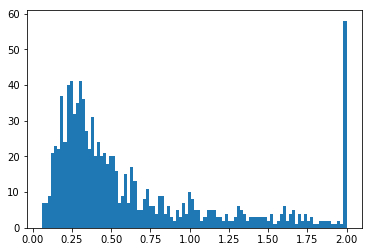

In [52]:
%pylab inline
plt.hist(lst,bins=100);
print np.mean(lst) 

301.5 317.557 0.172891


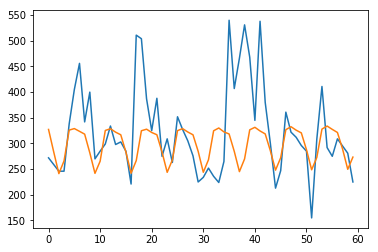

In [53]:
i=1233
u=Y[i][:60]
v=a[i]
plt.plot(u)
plt.plot(v)
print np.median(u),np.median(v), (2*np.abs(u-v)/(np.abs(u)+np.abs(v))).mean()

In [54]:
daily_data.shape,attrib_data.shape

((145063, 550), (145063, 12))

In [55]:
daily_test=daily_data[:,-LEN1:]
attrib_test=attrib_data
daily_test.shape,attrib_test.shape

((145063, 128), (145063, 12))

In [56]:
feed_dict={x:daily_test,x2:attrib_test}
predTest=sess.run(prediction,feed_dict=feed_dict)
predTest.shape

(145063, 60)

In [57]:
predTest=np.round(predTest,1)
np.mean(predTest<1)

4.791021831893729e-05

In [58]:
import datetime
cols=pd.date_range(pd.datetime.date(datetime.datetime(2017, 1, 1)), periods=60).map(lambda u: u.strftime("%Y-%m-%d"))
idx=pd.read_csv("../input/train_1.csv",usecols=[0])["Page"]
idx.shape

(145063,)

In [59]:
submission=pd.DataFrame(predTest,columns=cols,index=idx)
submission=submission.unstack().reset_index()
submission['name']=submission.apply(lambda r: r['Page']+"_"+r['level_0'],axis=1)
submission=submission.drop(['Page','level_0'],axis=1)
submission.columns=['Visits','name']

In [60]:
submission=submission[["name",'Visits']]
submission.head()

name  Visits
0  2NE1_zh.wikipedia.org_all-access_spider_2017-0...    19.9
1  2PM_zh.wikipedia.org_all-access_spider_2017-01-01    21.9
2   3C_zh.wikipedia.org_all-access_spider_2017-01-01     5.3
3  4minute_zh.wikipedia.org_all-access_spider_201...    14.3
4  52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...    12.1

In [61]:
keys=pd.read_csv("../input/key_1.csv",index_col=0)

In [62]:
keys_dict=keys["Id"].to_dict()

In [63]:
submission["Id"]=submission["name"].apply(lambda u:keys_dict[u])

In [64]:
submission.isnull().sum().sum()

0L

In [65]:
submission.head()

name  Visits            Id
0  2NE1_zh.wikipedia.org_all-access_spider_2017-0...    19.9  ff8c1aade3de
1  2PM_zh.wikipedia.org_all-access_spider_2017-01-01    21.9  3da6fd5b23c1
2   3C_zh.wikipedia.org_all-access_spider_2017-01-01     5.3  cd9e83803be4
3  4minute_zh.wikipedia.org_all-access_spider_201...    14.3  65cd4af0968c
4  52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...    12.1  75bae1fb2637

In [66]:
submission[["Id","Visits"]].to_csv("../submission/sub_pred_lstm1_60_512_nozero_xnopad_l2.csv.gz",
                                   index=None, float_format='%.1f', compression="gzip")